<a href="https://colab.research.google.com/github/xoxonut/nycu-cv-113-2/blob/main/CV_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar -xvzf "/content/drive/MyDrive/hw1-data.tar.gz" -C "/content" > /dev/null 2>&1
!du -sh "/content/data"
!awk 'BEGIN {sum=0} /^[0-9]+$/ {sum+=$1} END {print sum}' <(find "/content/data/train" -type f | wc -l) <(find "/content/data/val" -type f | wc -l)

6.5G	/content/data
21024


In [21]:
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import DataLoader,Dataset
from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import numpy as np


In [22]:
def get_transforms():
  train_transform = v2.Compose([
      v2.Lambda(lambda img: img.convert("RGB")),
      v2.Resize((224,224)),
      v2.ColorJitter(hue=.05, saturation=.05),
      v2.RandomHorizontalFlip(),
      v2.RandomRotation(20),
      v2.ToTensor(),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  test_transform = v2.Compose([
      v2.Lambda(lambda img: img.convert("RGB")),
      v2.Resize((224,224)),
      v2.ToTensor(),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return train_transform, test_transform

In [23]:
def create_dataloader(train_transform,test_transform,batch_size):
  class LabeledDataset(Dataset):
    def __init__(self,root_dir,transform=None):
      self.root_dir = root_dir
      self.transform = transform
      self.classes = os.listdir(root_dir)
      self.class_to_idx = {cls:int(cls) for cls in self.classes}
      self.image_paths = []
      self.labels = []
      for cls in self.classes:
        cls_dir = os.path.join(root_dir,cls)
        if os.path.isdir(cls_dir):
          for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir,img_name)
            if os.path.isfile(img_path):
              self.image_paths.append(img_path)
              self.labels.append(self.class_to_idx[cls])
    def __len__(self):
      return len(self.image_paths)
    def __getitem__(self,index):
      image_path = self.image_paths[index]
      image = Image.open(image_path)
      label = self.labels[index]
      if self.transform:
        image = self.transform(image)
      return image,label

  train_set = LabeledDataset("/content/data/train",transform=train_transform)
  val_set = LabeledDataset("/content/data/val",transform=test_transform)
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
  class TestDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
      self.root_dir = root_dir
      self.transform = transform
      valid_exts = (".jpg",".jpeg",".png",".bmp")
      self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(valid_exts)]

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, index):
      image_path = self.image_paths[index]
      image = Image.open(image_path)
      if self.transform:
        image = self.transform(image)
      file_name = os.path.basename(image_path)
      name_only = os.path.splitext(file_name)[0]
      return image,name_only
  test_set = TestDataSet("/content/data/test",transform=test_transform)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
  return train_loader,val_loader,test_loader

In [24]:
def train_one_epoch(model,train_loader,optimizer,criterion,device):
  model.train()
  total_loss, correct, total = 0, 0, 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    predicted = torch.argmax(outputs, dim=1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
  avg_loss = total_loss / len(train_loader)
  avg_acc = correct / total * 100
  return avg_loss, avg_acc

In [25]:
def validate(model,val_loader,criterion,device):
  model.eval()
  total_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  avg_loss = total_loss / len(val_loader)
  avg_acc = correct / total * 100
  return avg_loss, avg_acc

In [26]:
def test_model(model,test_loader,device):
  model.eval()
  correct, total = 0, 0
  predictions = []
  with torch.no_grad():
    for inputs, file_names in test_loader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      preds = torch.argmax(outputs, dim=1)

      for file_name, pred in zip(file_names, preds):
        predictions.append({"image_name": file_name,
                            "pred_label": pred.item()})
  return predictions


In [27]:
def init_RestNet50(num_classes):
  model = resnet50(weights=ResNet50_Weights.DEFAULT)
  num_ftrs = model.fc.in_features
  model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
  )
  for p in model.parameters():
    p.requires_grad = False
  for p in model.fc.parameters():
    p.requires_grad = True
  for p in model.layer4.parameters():
    p.requires_grad = True
  return model

In [28]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [29]:
def print_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())  # in bytes
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())  # in bytes
    total_size = (param_size + buffer_size) / (1024 ** 2)  # Convert to MB
    print(f"Model size: {total_size:.2f} MB")


Model size: 94.08 MB
Epoch 1/10 - Train Loss: 4.6644 - Train Acc: 1.89% - Val Loss: 4.6852 - Val Acc: 1.00%
Epoch 2/10 - Train Loss: 3.2820 - Train Acc: 13.02% - Val Loss: 4.6540 - Val Acc: 1.00%
Epoch 3/10 - Train Loss: 2.5723 - Train Acc: 25.94% - Val Loss: 7.5853 - Val Acc: 1.00%
Epoch 4/10 - Train Loss: 2.1982 - Train Acc: 30.80% - Val Loss: 7.3829 - Val Acc: 1.00%
Epoch 5/10 - Train Loss: 2.0884 - Train Acc: 31.78% - Val Loss: 6.1997 - Val Acc: 1.00%
Epoch 6/10 - Train Loss: 1.9589 - Train Acc: 35.30% - Val Loss: 8.9042 - Val Acc: 1.00%
Epoch 7/10 - Train Loss: 1.8975 - Train Acc: 35.97% - Val Loss: 18.8381 - Val Acc: 1.00%
Epoch 8/10 - Train Loss: 1.9160 - Train Acc: 36.32% - Val Loss: 14.0824 - Val Acc: 1.00%
Epoch 9/10 - Train Loss: 1.8710 - Train Acc: 35.36% - Val Loss: 12.9087 - Val Acc: 1.00%
Epoch 10/10 - Train Loss: 1.7674 - Train Acc: 38.87% - Val Loss: 20.0665 - Val Acc: 1.00%


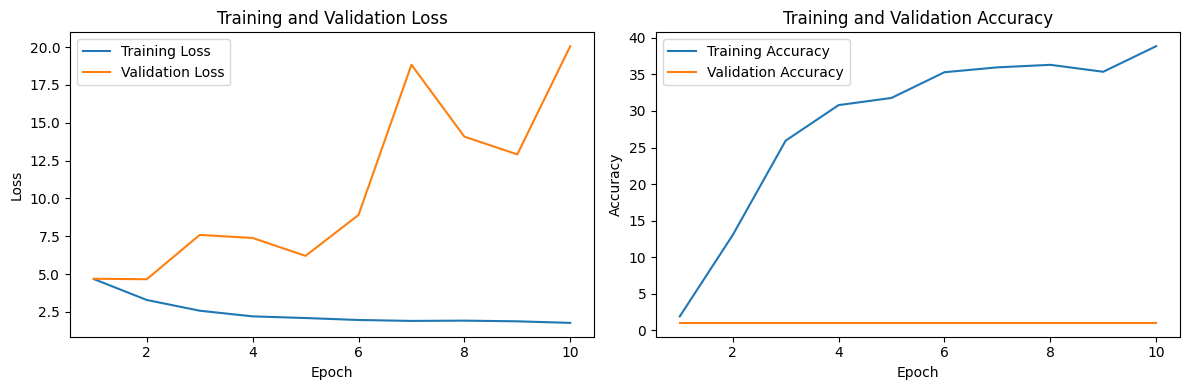

In [30]:
if __name__ == "__main__":
  train_transform,test_transform = get_transforms()
  train_loader,val_loader,test_loader = create_dataloader(train_transform,test_transform,32)
  model = init_RestNet50(100)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.01)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
  epochs = 10
  train_losses, train_accs, val_losses, val_accs = [], [], [], []
  print_model_size(model)
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    torch.save(model,"/content/drive/MyDrive/full_model.pth")
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
  plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)
  res = test_model(model,test_loader,device)
  df = pd.DataFrame(res)
  df.to_csv("/content/drive/MyDrive/prediction.csv",index=False)
